<a href="https://colab.research.google.com/github/joshmurr/machine-learnings/blob/master/cci-dsai/ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install imageio scikit-image
!pip -q install git+https://github.com/tensorflow/docs

In [150]:
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0) # To make results replicatable

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

# Import the Model using TF-Hub

In [31]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

In [23]:
progan.signatures

_SignatureMap({'default': <ConcreteFunction pruned(latent_vector) at 0x7F6C97DA2BD0>})

# Generate an Image

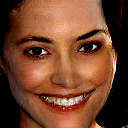

In [151]:
z = tf.random.normal([latent_dim])
image = progan(z)['default']
display_image(image[0])

# Generate a Bunch of Images

In [109]:
def image_grid(x, size=6):
    t = tf.unstack(x[:size * size], num=size*size, axis=0)
    rows = [tf.concat(t[i*size:(i+1)*size], axis=0) 
            for i in range(size)]
    image = tf.concat(rows, axis=1)
    return image[None]

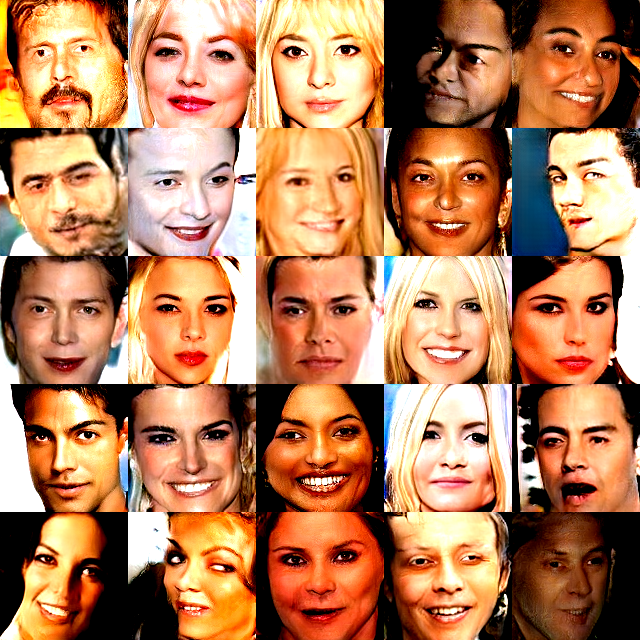

In [153]:
bag_of_zs = tf.random.normal([25, latent_dim])
images = progan(bag_of_zs)['default']
grid = image_grid(images, size=5)

display_image(grid[0])

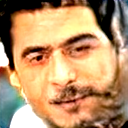

In [154]:
display_image(images[1])

In [147]:
def interpolate_between_vectors(_v1=tf.random.normal([latent_dim]),
                                _v2=tf.random.normal([latent_dim])):
  v1 = _v1 
  v2 = _v2
    
  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

#interpolated_images = interpolate_between_vectors()
#animate(interpolated_images)


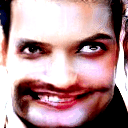

In [148]:
interpolated_images = interpolate_between_vectors(bag_of_zs[1], bag_of_zs[3])
animate(interpolated_images)

Saving hi.png to hi (1).png


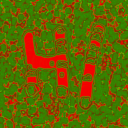

In [155]:
image_from_module_space = False  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

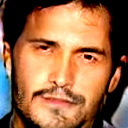

In [157]:
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [158]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      image = tf.cast(image, dtype=tf.double)
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.cast(tf.abs(tf.norm(vector) - np.sqrt(latent_dim)), dtype=tf.float64)

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))
    
  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 5575.494332122803)

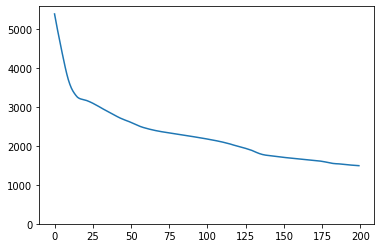

In [159]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


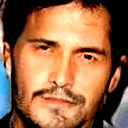

In [161]:
animate(np.stack(images))

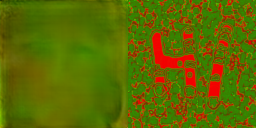

In [170]:
display_image(np.concatenate([images[-1], target_image[:,:,:3]], axis=1))